# Cluster 17

In [1]:
import gizmo_analysis as gizmo
import utilities as ut
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
#from mpl_toolkits.mplot3d import Axes3D
from sl_utilities import distinct_colours as dc
from sl_utilities import distance_functions
import os
import pickle
from fof_analysis import fof

In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home1/07428/binod/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home1/07428/binod/anaconda3/lib/

In [2]:
!hostname
!pwd

c506-091.stampede2.tacc.utexas.edu
/home1/07428/binod


In [3]:
simname = 'm12i_res7100_mhdcv'
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/'
simtype="fire2"
snapnumber=596
snap=snapnumber

#data_path="/home1/07428/binod/stampede_workfolder/fire2/fire2_data_pkl/" 
#gas_datapath="/home1/07428/binod/stampede_workfolder/fire2/fire2_gas_data_pkl/"

#gas_file_name=simtype+"_gas_data"+str(snapnumber)+".pkl"
#cluster_data_name="all_clusters_at_snapshot_"+str(snapnumber)+".pkl" 

#############################################################################
#constants
#############################################################################

MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.

bins = np.arange(-5,5,0.1)
#bins = np.arange(-25,25,0.1)


# Extracting age, location and metallicity information for the simulations

In [4]:
part=gizmo.io.Read.read_snapshots(['star'],'snapshot_index', snap, simulation_name=simname, simulation_directory=simdir, assign_hosts=True, assign_hosts_rotation=True)               #snap is the snapshot number here that changes everytime the loop iterates. It starts with sanpshot_start

age=part['star'].prop('age')
x=part['star'].prop('host.distance.principal')[:,0] #x component of the position of all stars 
y=part['star'].prop('host.distance.principal')[:,1] #y component of the position of all stars
z=part['star'].prop('host.distance.principal')[:,2] #z component of the position of all stars
Rxy = part['star'].prop('host.distance.principal.cylindrical')[:,0]
rxyz     = part['star'].prop('host.distance.total')
mass     = part['star'].prop('mass')

ids      = part['star'].prop('id')
id_child = part['star'].prop('id.child')
age      = part['star'].prop('age')

feh = part['star'].prop('metallicity.fe')
mgh = part['star'].prop('metallicity.mg')


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/snapshot_times.txt

  using snapshot index = 596, redshift = 0.007


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/output/snapdir_596/snapshot_596.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 70514272 particles
    dark2     (id = 2): 5513331 particles
    gas       (id = 0): 55685704 particles
    star      (id = 4): 15298647 particles
    blackhole (id = 5): 0 particles

* reading species: ['star']
* reading particles from:
    snapshot_596.0.hdf5
    snapshot_596.1.hdf5
    snapshot_596.2.hdf5
    snapshot_596.3.hdf5

* reading cosmological parameters from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12i_res7100/mhdcv/1Myr/fire2/initial_condition/ic_agora_m12i.conf

* checking sanity of particle properties
! warning: star

In [5]:
#select young stars within the disk for star clusters
keep = np.where((age <= .003) & ((Rxy < 20) & (Rxy>2)) & (abs(z) < 1.5))
#to run cluster finding on
rxyz0     = rxyz[keep]
Rxy0      = Rxy[keep]
x0        = x[keep]
y0        = y[keep]
z0        = z[keep]
mass0     = mass[keep]
feh0      = feh[keep]
mgh0      = mgh[keep]

id0       = ids[keep]
id_child0 = id_child[keep]
age0      = age[keep]

In [6]:
linking_length = 0.01 #10 parsec (unit here is in kpc)
ncut           = 10 #5 star particles
ind, xcm, ycm, zcm, mtot, grpid, r90, r50, rmax =fof.find(x0,y0,z0, b=linking_length, mass=mass0, ncut=ncut)
ngroup = len(mtot)

linking length  0.01
min number particles in group  10
0.10235357284545898 seconds
number of groups 16
max number in a group 43


# Loading cluster data and gas data

In [7]:
export_cluster={}
for grp_index in range(ngroup):  #iterate over each group
    cluster={}
    ids_in_cluster = id0[ind[grp_index]]  #these are the star particle ids in each cluster
    id_children_in_cluster = id_child0[ind[grp_index]]
    age_cluster=age0[ind[grp_index]]
    nstar = len(ids_in_cluster)
    groupid=grpid[grp_index]
    print('------------------------------------------------------------------------------------------------------------------')
    print('grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)')
    print('%s     %i     %.4f     %.4f    %.4f     %.2e     %.1f ' % (grpid[grp_index], nstar, xcm[grp_index], ycm[grp_index], zcm[grp_index], mtot[grp_index], 1000*rmax[grp_index]))
    print("age of stars in the cluster",age_cluster)
    print('ids')
    string = '[' 
    for i in ids_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)

    print('id children')
    string = '[' 
    for i in id_children_in_cluster:
        string = string + str(i) + ', '

    #get rid of last extra ,
    length = len(string)-2
    string = string[0:length] + ']'
    print(string)
    print("These are the ids printed",ids_in_cluster)
    #feh_in_cluster=feh0[ind[grp_index]]
    #cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]],"ch":ch0[ind[grp_index]],"nh":nh0[ind[grp_index]],"oh":oh0[ind[grp_index]],"neh":neh0[ind[grp_index]],"sih":sih0[ind[grp_index]],"sh":sh0[ind[grp_index]],"cah":cah0[ind[grp_index]],"mgfe":mgfe0[ind[grp_index]],"ofe":ofe0[ind[grp_index]],"sife":sife0[ind[grp_index]],"sfe":sfe0[ind[grp_index]],"cafe":cafe0[ind[grp_index]],"nefe":nefe0[ind[grp_index]]}
    cluster={"cluster_groupid":groupid,"no_of_star":nstar,"id":ids_in_cluster,"id_children":id_children_in_cluster,"xcm":xcm[grp_index],"ycm":ycm[grp_index],"zcm":zcm[grp_index],"mtot":mtot[grp_index],"r90":r90[grp_index],"r50":r50[grp_index],"rmax":rmax[grp_index],"x":x0[ind[grp_index]],"y":y0[ind[grp_index]],"z":z0[ind[grp_index]],"age":age0[ind[grp_index]],"feh":feh0[ind[grp_index]],"mgh":mgh0[ind[grp_index]]}

    export_cluster.update({groupid:cluster})


------------------------------------------------------------------------------------------------------------------
grpid, nstar, xcm (kpc), ycm (kpc), zcm (kpc), mtot (msun), rmax (pc)
1     43     -6.0073     6.0728    0.1123     4.95e+05     14.0 
age of stars in the cluster [2.24651479e-04 8.28341143e-04 1.34115589e-03 3.98085611e-04
 9.12414719e-05 1.52109695e-04 1.57946382e-04 8.28341143e-04
 1.05431180e-03 2.24651479e-04 2.13811888e-04 2.34657260e-04
 3.98085611e-04 3.78073916e-04 9.10891061e-04 6.84921765e-04
 1.40202732e-03 5.41503254e-04 1.95571435e-03 7.46625344e-04
 1.11252925e-04 8.04019418e-05 1.52109695e-04 1.13602866e-03
 5.21491438e-04 1.38201478e-03 8.69440557e-06 1.72955012e-04
 5.62348914e-04 3.88079761e-04 1.50459187e-03 1.62800345e-03
 2.54668835e-04 1.01247196e-04 6.03905145e-05 8.04019418e-05
 1.95339030e-05 1.22092469e-04 1.62949258e-04 1.72955012e-04
 2.34657260e-04 2.95395972e-05 1.25860448e-03]
ids
[21964074, 13285005, 30978536, 68630449, 45857179, 47786639, 

In [8]:
cluster_group=1
export_cluster[cluster_group].keys()

dict_keys(['cluster_groupid', 'no_of_star', 'id', 'id_children', 'xcm', 'ycm', 'zcm', 'mtot', 'r90', 'r50', 'rmax', 'x', 'y', 'z', 'age', 'feh', 'mgh'])

In [9]:
ind=export_cluster[1]["feh"]
print(feh)
print(export_cluster[1]["x"])
print(export_cluster[1]["r90"])


[-2.0814083 -1.21252   -1.3928102 ... -1.169801  -1.2236117 -1.7191033]
[-6.00307966 -6.00349799 -5.99988107 -6.00310962 -6.0017005  -6.00654862
 -6.00698674 -6.00554434 -6.0050974  -6.00808298 -6.00762546 -6.00812528
 -6.01068292 -6.00328777 -6.00619153 -6.00745984 -6.00777392 -6.00678715
 -6.0006055  -6.00562482 -6.00646929 -6.00540532 -6.00503285 -6.00668641
 -6.00979852 -6.00419566 -6.00853963 -6.00964962 -6.0024964  -6.00964411
 -6.01415946 -6.0062386  -6.00951576 -6.00939451 -6.01092185 -6.01307867
 -6.00950509 -6.00960962 -6.00954438 -6.00964288 -6.01100886 -6.01159239
 -6.01534861]
0.009604226707545014


# Locating the CM of the cluster

In [10]:
xcm=export_cluster[cluster_group]["xcm"]
ycm=export_cluster[cluster_group]["ycm"]
print("The cluster is located at:",(xcm,ycm))
radius=((xcm)**2+(ycm)**2)**(1/2)
print("The cluster CM is at radius: ",radius)

circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
print(len(circle_radius))

cm_R=list()
for i in export_cluster:
    xcm=export_cluster[i]["xcm"]
    ycm=export_cluster[i]["ycm"]
    radius=((xcm)**2+(ycm)**2)**(1/2)
    cm_R.append(radius)
    

print(cm_R)


The cluster is located at: (-6.007335501751587, 6.072812012658155)
The cluster CM is at radius:  8.542079698275485
15298647
[8.542079698275485, 8.377818342008291, 7.269312278960123, 9.121051204780578, 7.568216071203412, 6.05867245602863, 7.298719833188445, 13.090947848338857, 4.174343238454306, 7.160994715543686, 6.426306455847568, 7.8935588338106015, 4.009661754254098, 13.030381289833587, 5.461061312766238, 12.924026626242185]


In [42]:
region=np.linspace(1,20,20)/10
print(region)
print(cluster_group)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
1


(1.0, 0.196078431372549, 0.196078431372549, 1.0)
#ff3232
[8.542079698275485, 8.377818342008291, 7.269312278960123, 9.121051204780578, 7.568216071203412, 6.05867245602863, 7.298719833188445, 13.090947848338857, 4.174343238454306, 7.160994715543686, 6.426306455847568, 7.8935588338106015, 4.009661754254098, 13.030381289833587, 5.461061312766238, 12.924026626242185]
13.090947848338857


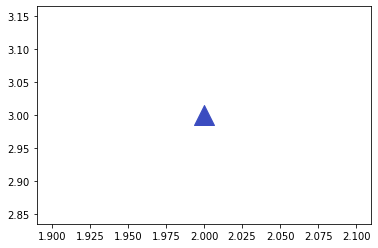

In [70]:
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

cmap = plt.cm.get_cmap('bwr')
#cmap = matplotlib.cm.get_cmap('bwr')
print(cmap)
rgba = cmap(0.9)
print(rgba)
clr=colors.rgb2hex(rgba)
print(clr)


def gen_color(see_map,n):
    '''Generates n distinct color from a given colormap%%!
    Returns: a list with hex values of colors
    '''
    cmap = plt.cm.get_cmap(str(see_map)) # select the desired cmap
    arr=np.linspace(0,1,n) #create a list with numbers from 0 to 1 with n items
    colorlist=list()
    for c in arr:
        rgba=cmap(c) #select the rgba value of the cmap at point c which is a number between 0 to 1
        clr=colors.rgb2hex(rgba) #convert to hex
        colorlist.append(str(clr)) # create a list of these colors
    return colorlist


def gen_color_normalized(see_map,data_arr):
    '''Generates n distinct color from a given colormap for a an array with data
    Returns: a list with hex values of colors
    '''
    cmap = plt.cm.get_cmap(str(see_map)) # select the desired cmap
    data_min=np.min(data_arr)
    data_max=np.max(data_arr)
    
    colorlist=list()
    for c in data_arr:
        norm=(c-data_min)/(data_max-data_min)*0.99
        rgba=cmap(norm) #select the rgba value of the cmap at point c which is a number between 0 to 1
        clr=colors.rgb2hex(rgba) #convert to hex
        colorlist.append(str(clr)) # create a list of these colors
    return colorlist




c_list=gen_color("bwr",16)

normalized_c_list=gen_color_normalized("coolwarm",cm_R)


plt.scatter(2,3,c=normalized_c_list[12],marker="^",s=400)

print(cm_R)
print(cm_R[7])


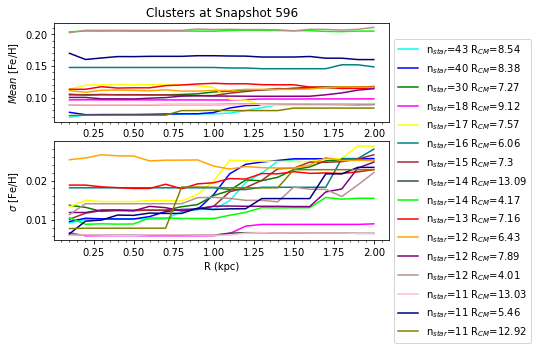

In [29]:
colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
fig1=plt.figure()
ax=fig1.add_subplot(212)
ax0=fig1.add_subplot(211)

for cluster_group in export_cluster:
    sigma_f=list()
    mean_f=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_feh=export_cluster[cluster_group]["feh"]
    cluster_feh_sigma=np.std(cluster_feh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    #print("The cluster CM is at radius: ",round(radius,2))
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        feh_region=feh[keep]
        sigma_feh_region=np.std(feh_region)
        mean_feh_region=np.mean(feh_region)
        sigma_f.append(sigma_feh_region)
        mean_f.append(mean_feh_region)

    #print(sigma_f)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_f,label=label_text,c=colors[cluster_group-1])
    ax0.plot(region,mean_f,label=label_text,c=colors[cluster_group-1])

    #ax.scatter(r90_cluster,cluster_feh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Fe/H]")
ax.minorticks_on()
ax.legend(bbox_to_anchor=(1,0.5), loc='center left')

ax0.set_title("Clusters at Snapshot "+str(snapnumber))
#ax0.set_xlabel("R (kpc)")
ax0.set_ylabel(r"$Mean$ [Fe/H]")
ax0.minorticks_on()
fig1.savefig("sigma_feh_region_new_data.jpg",bbox_inches='tight',dpi=200)
plt.show()

# Mgh

In [ ]:
colors=['cyan','blue','green','magenta','yellow','teal','brown','darkslategray','lime','red','orange','purple','rosybrown','pink','navy','olive','cornflowerblue','blueviolet','darkgreen'] #19 colors
fig1=plt.figure()
ax=fig1.add_subplot(111)

for cluster_group in export_cluster:
    sigma_mgh=list()
    xcm=export_cluster[cluster_group]["xcm"]
    ycm=export_cluster[cluster_group]["ycm"]
    r90_cluster=export_cluster[cluster_group]["r90"]
    cluster_mgh=export_cluster[cluster_group]["mgh"]
    cluster_mgh_sigma=np.std(cluster_mgh)
    radius=((xcm)**2+(ycm)**2)**(1/2)
    print("The cluster CM is at radius: ",radius)
    circle_radius=((x-xcm)**2+(y-ycm)**2)**(1/2)
    for r in region:
        keep = np.where((age <= .003) & (circle_radius<=r) & (abs(z) < 1.5))
        mgh_region=mgh[keep]
        sigma_mgh_region=np.std(mgh_region)
        sigma_mgh.append(sigma_mgh_region)

    #print(sigma_mgh)
    nstar=len(export_cluster[cluster_group]["x"])
    label_text=r"n$_{star}$="+str(nstar)+r" R$_{CM}$="+str(round(radius,2))
    ax.plot(region,sigma_mgh,label=label_text,c=colors[cluster_group-1])
    #ax.scatter(r90_cluster,cluster_mgh_sigma,marker="*",c=colors[cluster_group-1])

ax.set_xlabel("R (kpc)")
ax.set_ylabel(r"$\sigma$ [Mg/H]")
ax.minorticks_on()
ax.legend(bbox_to_anchor=(1,0.5), loc='center left')
ax.set_title("Clusters at Snapshot "+str(snapnumber))
fig1.savefig("sigma_mgh_region_new_data.jpg",bbox_inches='tight',dpi=200)